# A Machine Learning Approach to Equity Premium Prediction
By Shane Johnson (ND CS), Catherine Markley (ND CS), Yuanhao Niu (ND Econ), Nick Rocco (ND CS) 
<br>-- Fall 2018 CSE 40647/60647 Data Science Project

## Introduction
We try to use machine learning methods to predict equity premium based on predictors from the seminal paper of Goyal and Welch (2008). 

We first build and clean our dataset. Then we try to predict bull/bear market as a classification job. Portfolio based on the prediction were constructed accordingly. In a parallel task, we use different regression approaches to predict equity premium. Our models outperforme the historical average forecast. 

## Data Cleaning

Raw data are downloaded from Prof. Goyal's webside. We included their orginal monthly data from 1926/12 to 2013/12.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("raw_predictors_until2013.csv")

Generate the predictors based on the raw data, as in Welch and Goyal (2008)

In [2]:
# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['CRSP_SPvw'] - df['Rfree']

# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices. 
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated cor- porate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
df['dfr'] = df['corpr'] - df['ltr']

In [3]:
# drop the first observation for 1926/12 (used it to calculate lagged value)
df = df[1:]

We generate indicators for bull market.

In [4]:
sLength = len(df['yyyymm'])
# add the bullMarket column with random ints (to be replaced in next cell)
df['bull'] = pd.Series(np.random.randn(sLength), index=df.index)
# Create bullMarkert for ret
bull = []
for d in df['CRSP_SPvw']:
    if d > 0:
        bull.append(1)
    else:
        bull.append(0)
df['bull'] = bull

In [5]:
# drop the redundent variables
df = df.drop(columns=['Index','D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

In [6]:
# The Cross-Sectional Premium (csp) was only available from May 1937 to December 2002. 
# We compute the average of the data and fill the missing values with the average value.
pd.options.mode.chained_assignment=None
df['csp'][0:124] = df['csp'][124:911].mean()
df['csp'][912:]  = df['csp'][124:911].mean()

We calculate the benchmark (historical average) prediction

In [7]:
premium = 0
count = 0

temp = df['premium']

his_avg = []

for i in temp:
    premium += i
    count += 1
    his_avg.append(premium/count)

df['his_avg'] = his_avg

Now we had the CONTEMPORANEOUS dataset to work on!

In [8]:
# reorganize the dataframe
df = df[['yyyymm','Month','his_avg','bull','premium','d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl']]
df.head(5)

,yyyymm,Month,his_avg,bull,premium,d/p,d/y,e/p,d/e,svar,csp,b/m,ntis,tbl,lty,ltr,tms,dfy,dfr,infl
1,192701,1,-0.005602,0,-0.005602,-2.942374,-2.963349,-2.374773,-0.567601,0.000470,0.00037,0.443706,0.050834,0.0323,0.0351,0.0075,0.0028,0.0095,-0.0019,-0.011299
2,192702,2,0.018589,1,0.042780,-2.979535,-2.932946,-2.430353,-0.549182,0.000287,0.00037,0.428501,0.051682,0.0329,0.0347,0.0088,0.0018,0.0092,-0.0019,-0.005714
3,192703,3,0.013945,1,0.004657,-2.976535,-2.970053,-2.445079,-0.531456,0.000924,0.00037,0.469765,0.046370,0.0320,0.0331,0.0253,0.0011,0.0092,-0.0170,-0.005747
4,192704,4,0.013008,1,0.010196,-2.984225,-2.967143,-2.471309,-0.512916,0.000603,0.00037,0.456754,0.050518,0.0339,0.0333,-0.0005,-0.0006,0.0090,0.0060,0.000000
5,192705,5,0.022322,1,0.059578,-3.025963,-2.975058,-2.531446,-0.494518,0.000392,0.00037,0.434783,0.055279,0.0333,0.0327,0.0109,-0.0006,0.0093,-0.0120,0.005780


Plot the heatmap of feature correlation

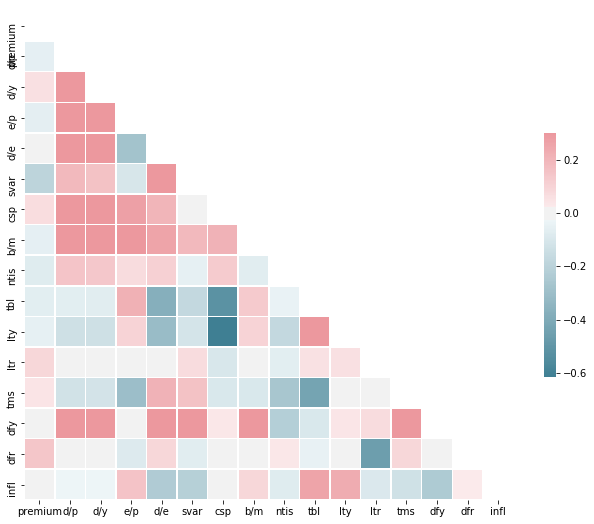

In [10]:
features = df[['premium','d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl']]

corr = features.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We make a forecst of t+1 period label conditioning on all the avaiable information at t.

In [11]:
past = 2

num = len(df.columns)
for i in range(4,num):
    name = df.columns[i]
    for j in range(1,past):
        t = str(j)
        df[name+"-"+t] = df[name].shift(j)

In [12]:
# drop the first period predictors
df = df[past-1:]

In [13]:
# drop the contemporanous predictors
df = df.drop(columns=['d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl'])

In [14]:
# column number 3845: 'yyyymm','Month',‘his_avg’，'bull','premium' + 16 indicator 
len(df.columns)

21

In [15]:
# now the features include the past 20 years observations
df.head(5)

,yyyymm,Month,his_avg,bull,premium,premium-1,d/p-1,d/y-1,e/p-1,d/e-1,...,csp-1,b/m-1,ntis-1,tbl-1,lty-1,ltr-1,tms-1,dfy-1,dfr-1,infl-1
2,192702,2,0.018589,1,0.042780,-0.005602,-2.942374,-2.963349,-2.374773,-0.567601,...,0.00037,0.443706,0.050834,0.0323,0.0351,0.0075,0.0028,0.0095,-0.0019,-0.011299
3,192703,3,0.013945,1,0.004657,0.042780,-2.979535,-2.932946,-2.430353,-0.549182,...,0.00037,0.428501,0.051682,0.0329,0.0347,0.0088,0.0018,0.0092,-0.0019,-0.005714
4,192704,4,0.013008,1,0.010196,0.004657,-2.976535,-2.970053,-2.445079,-0.531456,...,0.00037,0.469765,0.046370,0.0320,0.0331,0.0253,0.0011,0.0092,-0.0170,-0.005747
5,192705,5,0.022322,1,0.059578,0.010196,-2.984225,-2.967143,-2.471309,-0.512916,...,0.00037,0.456754,0.050518,0.0339,0.0333,-0.0005,-0.0006,0.0090,0.0060,0.000000
6,192706,6,0.014780,0,-0.022928,0.059578,-3.025963,-2.975058,-2.531446,-0.494518,...,0.00037,0.434783,0.055279,0.0333,0.0327,0.0109,-0.0006,0.0093,-0.0120,0.005780


Here we plot the distribution of the equity premium. The returns are left-skewed (i.e. negative skewness).

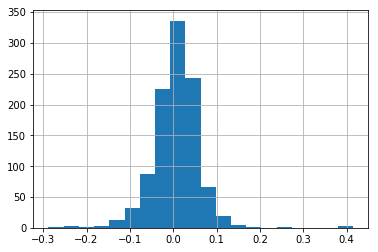

In [16]:
hist = df["premium"].hist(bins=20)

## Classification (Bull Market Prediction)

For classification purpose, we first normalize the features 

In [17]:
bull = df.bull
x = df.iloc[:,5:]
norm_x = (x- x.mean())/x.std(ddof=0)

We use the first half as training data and the second half as testing data

In [18]:
norm_x_train = norm_x[0:int(0.8*len(norm_x))]
norm_x_test = norm_x[int(0.8*len(norm_x)):]
bull_train = bull[0:int(0.8*len(norm_x))]
bull_test = bull[int(0.8*len(norm_x)):]

Decision tree (CART algorithm_C4.5) 

In [19]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(norm_x_train, bull_train)
predicted = clf.predict(norm_x_test)
c_matrix = confusion_matrix(predicted,bull_test)

# precision = True Positive/(True Positive + False Positive)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
# Recall = True Positive/(True Positive + False Negative)
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: " ,"\n" ,"[True Negative , False Positive", "\n","False Negative, True Positive]", "\n" ,c_matrix)  

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix:  
 [True Negative , False Positive 
 False Negative, True Positive] 
 [[32 48]
 [47 82]]
precision:  0.6308
recall:  0.6357


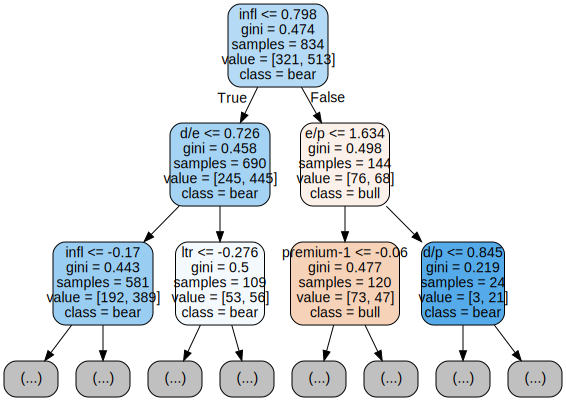

In [20]:
import graphviz 
dot_data = tree.export_graphviz(clf,
                                feature_names=['premium-1','d/p','d/y','e/p','d/e','svar','csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl'],
                                class_names= ['bull','bear'],
                                out_file=None,
                                max_depth = 2,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)  
graph 

### Low inflation as a strong indicator for bear market

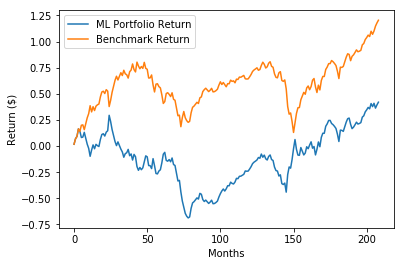

In [21]:
temp = df['premium']
premium = temp[int(0.8*len(norm_x)):]
cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(int(len(predicted))):
    if predicted[i] == 1:
        cumsum += premium[i+836]
    else:
        cumsum += -1*premium[i+836]
#         unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+836]
    cs_h.append(cumsum_h)
    
plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

K-Means (K=7)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(norm_x_train, bull_train)
predicted= clf.predict(norm_x_test)

c_matrix = confusion_matrix(predicted,bull_test)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: " ,"\n" ,"[True Negative , False Positive", "\n","False Negative, True Positive]", "\n" ,c_matrix)     

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix:  
 [True Negative , False Positive 
 False Negative, True Positive] 
 [[  8  14]
 [ 71 116]]
precision:  0.8923
recall:  0.6203


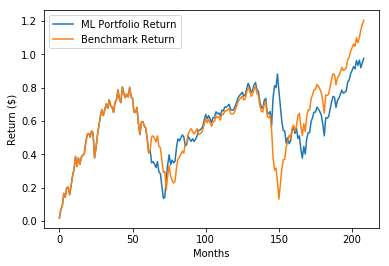

In [23]:
temp = df['premium']
premium = temp[int(len(temp)/2):]

cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(len(predicted)):
    if predicted[i] == 1:
        cumsum += premium[i+836]
    else:
        cumsum += -1*premium[i+836]
        # unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+836]
    cs_h.append(cumsum_h)
    
plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

## Regression (Equity Premium Prediction)

In [142]:
ret = df.premium
x = df.iloc[:,4:]

We will first start with the simplest linear regression model. 

In [143]:
# Here are 67 years of data prior to 2013 
# Spilt the data into 7 folds and cross-validate
# In each sample we have around 10 years of data

pd.options.mode.chained_assignment=None
import math
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.cross_validation import KFold

kf = KFold(x.shape[0],n_folds=7, shuffle=True)


diff_MAE = []
diff_RMSE = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]

    regr = linear_model.LinearRegression()
    regr.fit(x_train, ret_train)

    ret_pred = regr.predict(x_test)

    
    diff = df['his_avg'].iloc[test_index] - df['premium'].iloc[test_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(test_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    print("MAE of regression: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4))

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


MAE of regression:  0.008048333770433132
MAE of hist average:  0.00515315257338971
Diff MAE:  -0.0028951811970434217
RMSE of regression:  0.00010014956285362834
RMSE of hist average:  0.039741222058134955
Diff RMSE:  0.03964107249528133
adjusted R2: 1.0019532594410034
-------------------------------------------------------------------
MAE of regression:  0.007740374177464245
MAE of hist average:  0.005587463837539477
Diff MAE:  -0.002152910339924768
RMSE of regression:  9.386462957548477e-05
RMSE of hist average:  0.040980263177127774
Diff RMSE:  0.040886398547552286
adjusted R2: 1.0017049841884225
-------------------------------------------------------------------
MAE of regression:  0.010514353766484411
MAE of hist average:  0.005697696477008201
Diff MAE:  -0.004816657289476211
RMSE of regression:  0.00019343503779616178
RMSE of hist average:  0.04605211021996715
Diff RMSE:  0.04585867518217099
adjusted R2: 1.0027699005155797
----------------------------------------------------------

## Note:
Diff_MAE = MAE of Historical Average - MAE of current method  
Diff_MAE is Negative for linear regression: Linear model does a WORSE job on prediction.   
Diff_MAE is Positive for ML methods: ML methods beat the benchmark forecast.

Random Forrest

In [144]:
pd.options.mode.chained_assignment=None
from sklearn.ensemble import RandomForestRegressor

diff_MAE = []
diff_RMSE = []
in_sample = []
out_sample = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]
    
    regr = RandomForestRegressor(max_depth=25, random_state=0, n_estimators=25)
    regr.fit(x_train, ret_train)
    
    ret_pred = regr.predict(x_test)
    ret_fit = regr.predict(x_train)
    
    diff = df['his_avg'].iloc[test_index] - df['premium'].iloc[test_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(test_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    in_sample.append(mean_absolute_error(ret_train, ret_fit))
    out_sample.append(mean_absolute_error(ret_test, ret_pred))
    
    print("MAE of regression_in: ", mean_absolute_error(ret_train, ret_fit))
    print("MAE of regression_out: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4), 
      "In-sample avg: ", round(sum(in_sample)/len(in_sample),4),
      "Out-sample avg: ", round(sum(out_sample)/len(out_sample),4))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


MAE of regression_in:  0.0004684632173754462
MAE of regression_out:  0.0008318186605938289
MAE of hist average:  0.00515315257338971
Diff MAE:  0.0043213339127958815
RMSE of regression:  4.233193552916601e-06
RMSE of hist average:  0.039741222058134955
Diff RMSE:  0.03973698886458204
adjusted R2: 1.0000825617709876
-------------------------------------------------------------------
MAE of regression_in:  0.0005188928816910979
MAE of regression_out:  0.0007126055132834755
MAE of hist average:  0.005587463837539477
Diff MAE:  0.0048748583242560015
RMSE of regression:  2.412315378283186e-06
RMSE of hist average:  0.040980263177127774
Diff RMSE:  0.04097785086174949
adjusted R2: 1.0000438179918896
-------------------------------------------------------------------
MAE of regression_in:  0.0004272013225987866
MAE of regression_out:  0.0019163840033902444
MAE of hist average:  0.005697696477008201
Diff MAE:  0.0037813124736179563
RMSE of regression:  0.00010841332366252862
RMSE of hist avera

Boosted Trees

In [145]:
from sklearn.ensemble import GradientBoostingRegressor

diff_MAE = []
diff_RMSE = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]
    
    regr = GradientBoostingRegressor(n_estimators=25, learning_rate=0.5, max_depth=25, random_state=0, loss='ls')
    regr.fit(x_train, ret_train)
    
    ret_pred = regr.predict(x_test)
    
    diff = df['his_avg'].iloc[train_index] - df['premium'].iloc[train_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(train_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    print("MAE of regression: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4))

MAE of regression:  0.0008857335446538282
MAE of hist average:  0.032321670148204605
Diff MAE:  0.031435936603550776
RMSE of regression:  3.967178712756121e-06
RMSE of hist average:  0.04225215916481874
Diff RMSE:  0.042248191986105986
adjusted R2: 1.000077373570628
-------------------------------------------------------------------
MAE of regression:  0.0007596410530923491
MAE of hist average:  0.03188735888405484
Diff MAE:  0.031127717830962492
RMSE of regression:  2.1807679260101003e-06
RMSE of hist average:  0.042054146292291074
Diff RMSE:  0.04205196552436506
adjusted R2: 1.0000396120972221
-------------------------------------------------------------------
MAE of regression:  0.001782416353861496
MAE of hist average:  0.03177712624458612
Diff MAE:  0.02999470989072462
RMSE of regression:  8.339333922440027e-05
RMSE of hist average:  0.041168863186441806
Diff RMSE:  0.04108546984721741
adjusted R2: 1.0011941541508989
----------------------------------------------------------------